In [ ]:
%%capture
!pip install pennylane --upgrade
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

Vamos a usar la librería PennyLane para implementar circuitos cuánticos variacionales. La idea va a ser armar de clasificadores que se entrenen con data etiquetada y sirvan para clasificar nuevas muestras. Esto está tomado de los trabajos de [Farhi and Neven (2018)](https://arxiv.org/abs/1802.06002) y de [Schuld et al. (2018)](https://arxiv.org/abs/1804.00633).

Vamos a ver primero como reproducir la función paridad dada por 

$f: x\in {0,1}^{\otimes n} \rightarrow y = \begin{cases}1\quad \text{si cantidad impar de unos en } x\\
0 \quad \text{en otro caso} \end{cases}$

Con esto vamos a demostrar como encodear inputs binarios en el estado inicial de un circuito variacional.

Después vamos a ver como encodear vectores reales como vectores de amplitud (amplitude encoding) y vamos a entrenar el modelo para reconocer las primeras dos clases de flores en el dataset de Iris.

# Fiteando la función paridad

Creamos un device con 4 cables (o qubits)

In [ ]:
dev = qml.device("default.qubit", wires=4)

En los circuitos variacionales se define siempre un "bloque", es decir un circuito elemental que se repite para construir el circuito variacional. 

En este caso vamos a tener rotaciones arbitrarias en cada qubit, y CNOTs para entrelazar cada qubit con su vecino.

In [ ]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

Necesitamos también una forma de encodear inputs de data $x$ en el circuito, de forma tal que el output medido dependa de los inputs. En el primer ejemplo, los inputs son strings de bits, que se encodean en el estado de los qubits. El estado cuántico $|\psi\rangle$ que tiene unos donde $x$ tiene unos es, por ejemplo

$x = 0101\rightarrow |\psi\rangle =|0101\rangle$

La función `BasisState` hace esta transformación por nosotros.

In [ ]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Definimos el nodo cuántico y la rutina de preparación del estado, seguida de una repetición en la estructura de capas.

In [ ]:
@qml.qnode(dev)
def circuit(weights, x=None):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

El nodo toma la data como argumento keyword $x$, que se considera fijo al calcular gradientes.

Para agregarle un parámetro clásico de bias, lo integramos en un post-procesado.

In [ ]:
def variational_classifier(var, x=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, x=x) + bias

### Costo

En supervised learning, la función de coste suele ser la suma de una función de pérdida y un regularizador. Usamos como perdida la square loss, que mide la distancia entre los labels del target y la predicción.

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

Definimos también una accuracy.

In [ ]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [ ]:
def cost(var, X, Y):
    predictions = [variational_classifier(var, x=x) for x in X]
    return square_loss(Y, predictions)

### Optimización

Descarguemos la data:

In [ ]:
%%capture
!pip install wget
import wget
import os
path = 'variational_classifier/data'
os.makedirs(path)
url = 'https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/parity.txt'
wget.download(url,out = path)

Carguemos la data:

In [ ]:
data = np.loadtxt("variational_classifier/data/parity.txt")
X = data[:, :-1]
Y = data[:, -1]
Y = Y * 2 - np.ones(len(Y))  # cambiamos los labels de {0, 1} a {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


Inicializamos las variables aleatoriamente (pero con semilla fija).

In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

print(var_init)

(tensor([[[ 0.01764052,  0.00400157,  0.00978738],
         [ 0.02240893,  0.01867558, -0.00977278],
         [ 0.00950088, -0.00151357, -0.00103219],
         [ 0.00410599,  0.00144044,  0.01454274]],

        [[ 0.00761038,  0.00121675,  0.00443863],
         [ 0.00333674,  0.01494079, -0.00205158],
         [ 0.00313068, -0.00854096, -0.0255299 ],
         [ 0.00653619,  0.00864436, -0.00742165]]], requires_grad=True), 0.0)


Creamos el optimizador y elegimos el batch size.

In [ ]:
from pennylane import NesterovMomentumOptimizer

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

Y entrenamos el optimizador. Trackeamos la accuracy (fracción de data clasificada correctamente). Para esto calculamos las predicciones y las proyectamos a $\{-1,1\}$

In [ ]:
var = var_init
for it in range(25):

    # Actualizamos los pesos en cada paso
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    var = opt.step(lambda v: cost(v, X_batch, Y_batch), var)

    # Calculamos la accuracy
    predictions = [np.sign(variational_classifier(var, x=x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(var, X, Y), acc
        )
    )

Iter:     1 | Cost: 3.4355534 | Accuracy: 0.5000000 
Iter:     2 | Cost: 1.9287800 | Accuracy: 0.5000000 
Iter:     3 | Cost: 2.0341238 | Accuracy: 0.5000000 
Iter:     4 | Cost: 1.6372574 | Accuracy: 0.5000000 
Iter:     5 | Cost: 1.3025395 | Accuracy: 0.6250000 
Iter:     6 | Cost: 1.4555019 | Accuracy: 0.3750000 
Iter:     7 | Cost: 1.4492786 | Accuracy: 0.5000000 
Iter:     8 | Cost: 0.6510286 | Accuracy: 0.8750000 
Iter:     9 | Cost: 0.0566074 | Accuracy: 1.0000000 
Iter:    10 | Cost: 0.0053045 | Accuracy: 1.0000000 
Iter:    11 | Cost: 0.0809483 | Accuracy: 1.0000000 
Iter:    12 | Cost: 0.1115426 | Accuracy: 1.0000000 
Iter:    13 | Cost: 0.1460257 | Accuracy: 1.0000000 
Iter:    14 | Cost: 0.0877037 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.0361311 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.0040937 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.0004899 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.0005290 | Accuracy: 1.0000000 
Iter:    19 | Cost: 0.0024304 | Accuracy: 1.00

# Clasificación de Iris

Ahora queremos guardar vectores con componentes reales en amplitudes de estados cuánticos. Vamos a usar un simulador de 2 qubits.

In [ ]:
dev = qml.device("default.qubit", wires=2)

Ahora cada input $x$ debe traducirse a un conjunto de ángulos. Vamos a trabajar, por simplicidad, con data solo de subespacio positivo (ignoramos signos, lo que requeriría una serie de rotaciones adicionales alrededor del eje z).

Vamos a seguir los trabajos de [Möttönen, et al. (2004)](https://arxiv.org/abs/quant-ph/0407010) y de 
[ Schuld and Petruccione (2018)](https://link.springer.com/book/10.1007/978-3-319-96424-9)

In [ ]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [ ]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Testeemoslo

In [ ]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)

In [ ]:
@qml.qnode(dev)
def test(angles=None):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(angles=ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev._state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [[ 5.38967743e-01  7.95036065e-01]
 [ 2.78265032e-01 -2.77555756e-17]]


Como estamos trabajando con solo 2 qubits, necesitamos actualizar la función de capa.

In [ ]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

Usamos el mismo modelo y función costo.

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

Cargamos la data de Iris. Tenemos que hacer un poco de preprocesado para guardar los inputs en amplitudes. Traducimos los inputs $x$ en ángulos de rotación usando `get_angles`.

In [ ]:
# Correr esta celda solo si no se corrió arriba (en función parity)
%%capture
!pip install wget
import wget
import os
path = 'variational_classifier/data'
os.makedirs(path)

In [ ]:
url = 'https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/iris_classes1and2_scaled.txt'
wget.download(url,out = path)

data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad en los vectores tamaño 2^2 con valores constantes
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalizamos cada input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# ángulos para la preparación de estados son nuevos features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


Visualicemos la data:

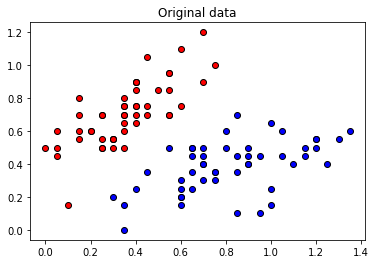

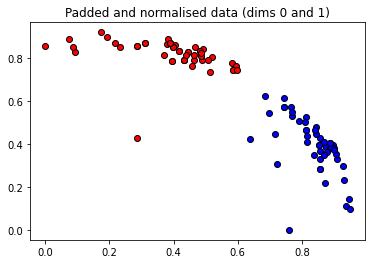

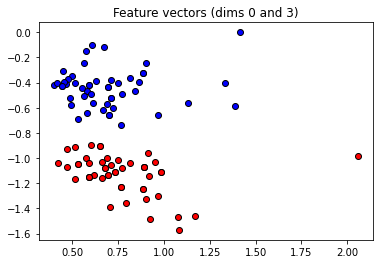

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

Divido en training y test

In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# Necesitamos para plotear
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

### Optimización

Inicializamos las variables:

In [ ]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

Optimizamos:

In [ ]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# entrenamos el clasificador variacional
var = var_init
for it in range(60):

    # Actualizamos los pesos en cada paso
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Calculamos las predicciones en los conjuntos de testeo y entrenamiento
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Calculamos la accuracy en los conjuntos de testeo y entrenamiento
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4490948 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3309953 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1582178 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9795035 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 0.8857893 | Acc train: 0.6400000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8587935 | Acc train: 0.7066667 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.8496204 | Acc train: 0.7200000 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8200972 | Acc train: 0.7333333 | Acc validation: 0.6800000 
Iter:     9 | Cost: 0.8027511 | Acc train: 0.7466667 | Acc validation: 0.6800000 
Iter:    10 | Cost: 0.7695152 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.7437432 | Acc train: 0.8133333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.7569196 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:    13 | Co

Podemos plotear el output continuo del classificador variacional para las primeras dos dimensiones del data set.

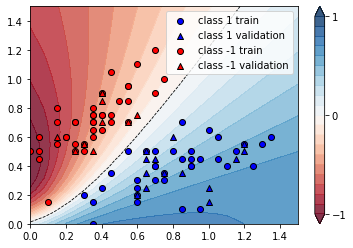

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# generamos data para las regiones de decisión
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocesamos los puntos del grid como los inputs de arriba
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad en cada input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalizamos cada input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # ángulos para la preparación de estados son nuevos features
predictions_grid = [variational_classifier(var, angles=f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# graficamos regiones de decisión
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# ploteamos data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()